# Project in Artificial Intelligence in Industry

Luigi Manieri - 0001113044

Irene Burri - 0001120380

This project aims to explore the geographical and architectural elements of the city of Bologna in order to find the best possible placement of green cells (100x100m), which will help in lot of ways to improve the quality of life of the citiziens.

The project was developed for the course Artificial Intelligence in Industry.

## Summary

This project was developed as follows:
- Data collection: where all the datasets were collected from different sources and meshed together to obtain a comprehensive dataset of geographical informations of the city of Bologna (later restricted to the city center)

- Data visualization: where info about the individual datasets are displayed

- Definition of the Optimization problem: we modelled the optimization problem as the problem of the most efficient way to place a grid of 100x100m cells over a given area of interest; 

    -   the grid starts from an origin and can have both an horizontal and vertical offset (that allow to move the grid around) as well as angles of rotation, so the two offsets and the rotation angle represent the parameters to optimize in the search space 

    -   every grid is evaluated through a scoring function that takes into account the coverage percentage of the geographical elements we take into account and the weight that we assign to each element (i.e. the presence of green areas is considered much positive when building new green areas)

    -   the grid obtaining the best score is selected and used to select which are the best cells in order to start enlarging the green areas of the city.

- Visualization of the results: after getting the optimal placement of the grid, we select the top 10% cells, that is the cells where it's best to start building new green areas

    -   This is done by plotting and also by creating an interactive map that can be viewed on browser and which highlights the best cells selected (with 2 different methods) as well as the geographical elements, for a more in-depth analysis.

## Importing Libraries and datasets

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona 
import os
import pandas as pd
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip
from folium.plugins import GroupedLayerControl
from shapely.ops import unary_union
import zipfile
from shapely.geometry import box, Polygon, Point
from shapely.affinity import rotate, translate
import random
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Unzip the complete dataset
zip_path = "Data/dataset_completo.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("Data")

gpkg_path = "Data\dataset_completo.gpkg"

layers = fiona.listlayers(gpkg_path)

print("Layers in GeoPackage:")
for layer in layers:
    print(layer)

Layers in GeoPackage:
037006_Bologna-2025-03-12T15Z — lines
037006_Bologna-2025-03-12T15Z — multilinestrings
037006_Bologna-2025-03-12T15Z — multipolygons
037006_Bologna-2025-03-12T15Z — other_relations
037006_Bologna-2025-03-12T15Z — points
aree-ortive
aree-statistiche
aree-verdi_entrate_centroidi
attrezzature_ludiche_ginniche_sportive
bagni-pubblici
cammini-e-percorsi
carta-tecnica-comunale-filari-siepi
carta-tecnica-comunale-marciapiedi
carta-tecnica-comunale-percorsi-pedonali
carta-tecnica-comunale-toponimi-parchi-e-giardini
piste-ciclopedonali
popolazione-arborea
portici
rastrelliere-per-biciclette
verde_privato_urbanizzato
zona-pedonale-centro-storico
layer_styles


# EDA

Here we perform an Exploratory data analysis, where we visualize each layer, cluster data based on themes and create an interactive map with the features we have.

Each layer represents different geographical elements and has an associated geometry (i.e. points for trees, lines for streets, etc.)

Layers were grouped in 5 main clusters:
-   OpenStreetMap layers (necessary for the map)
-   Mobility layers (i.e. paths and walk-only zones)
-   Green areas (i.e. trees)
-   Services (i.e. public toilets)
-   Technical info (i.e. streets)

## Visualize each layer

Found 22 layers.

=== Layer: 037006_Bologna-2025-03-12T15Z — lines ===
Number of features: 36734
Geometry type: ['LineString']
CRS: EPSG:4326
Columns: ['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags', 'geometry']
Missing values per column:
osm_id            0
name          26221
highway        9361
waterway      36419
aerialway     36734
barrier       33135
man_made      36589
railway       34872
z_order           0
other_tags     6286
geometry          0
dtype: int64


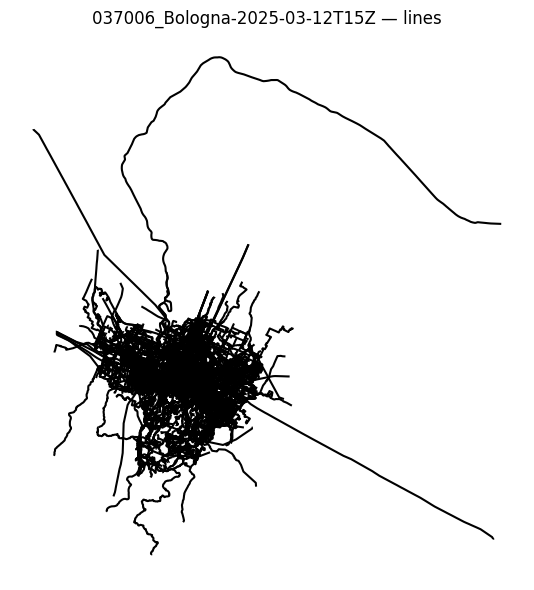



=== Layer: 037006_Bologna-2025-03-12T15Z — multilinestrings ===
Number of features: 509
Geometry type: ['MultiLineString']
CRS: EPSG:4326
Columns: ['osm_id', 'name', 'type', 'other_tags', 'geometry']
Missing values per column:
osm_id         0
name          13
type           0
other_tags     0
geometry       0
dtype: int64


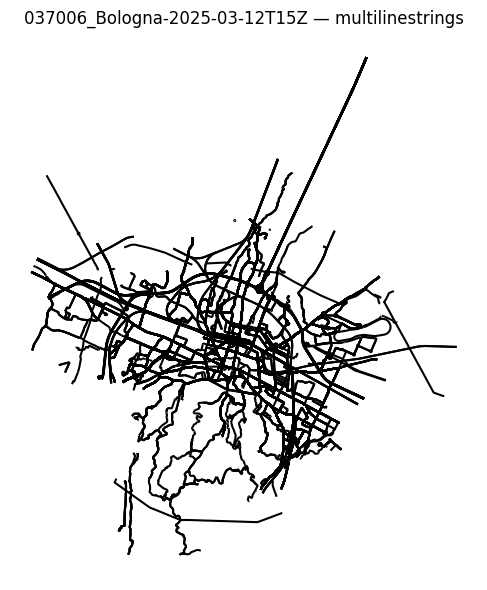



=== Layer: 037006_Bologna-2025-03-12T15Z — multipolygons ===
Number of features: 62007
Geometry type: ['MultiPolygon']
CRS: EPSG:4326
Columns: ['osm_id', 'osm_way_id', 'name', 'type', 'aeroway', 'amenity', 'admin_level', 'barrier', 'boundary', 'building', 'craft', 'geological', 'historic', 'land_area', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'shop', 'sport', 'tourism', 'other_tags', 'geometry']
Missing values per column:
osm_id         60561
osm_way_id      1446
name           59981
type           60557
aeroway        61946
amenity        58469
admin_level    61997
barrier        61933
boundary       61959
building       10159
craft          62007
geological     62007
historic       61922
land_area      62007
landuse        57891
leisure        60368
man_made       61878
military       62001
natural        61372
office         61969
place          61962
shop           61867
sport          61563
tourism        61949
other_tags     54470
geometry    

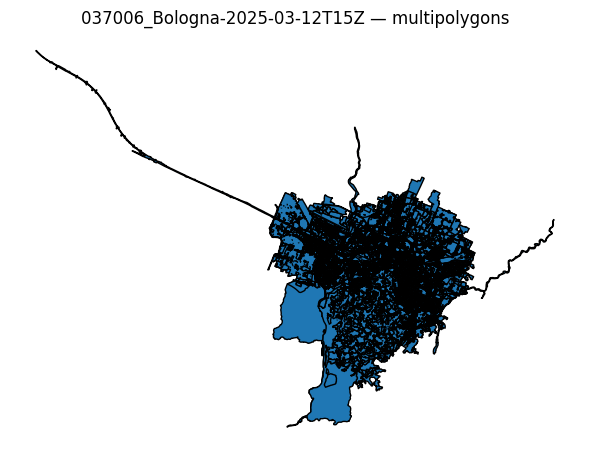



=== Layer: 037006_Bologna-2025-03-12T15Z — other_relations ===
Number of features: 1504
Geometry type: ['GeometryCollection']
CRS: None
Columns: ['osm_id', 'name', 'type', 'other_tags', 'geometry']
Missing values per column:
osm_id          0
name          803
type            0
other_tags     59
geometry        0
dtype: int64


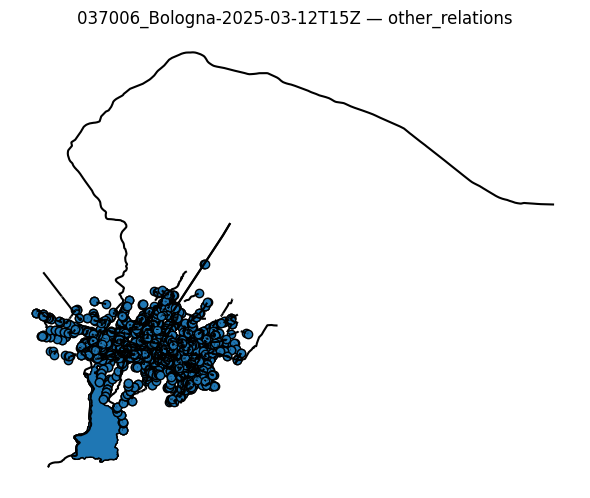



=== Layer: 037006_Bologna-2025-03-12T15Z — points ===
Number of features: 171737
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['osm_id', 'name', 'barrier', 'highway', 'ref', 'address', 'is_in', 'place', 'man_made', 'other_tags', 'geometry']
Missing values per column:
osm_id             0
name          163759
barrier       168290
highway       164967
ref           169235
address       171737
is_in         171737
place         171638
man_made      171467
other_tags      3763
geometry           0
dtype: int64


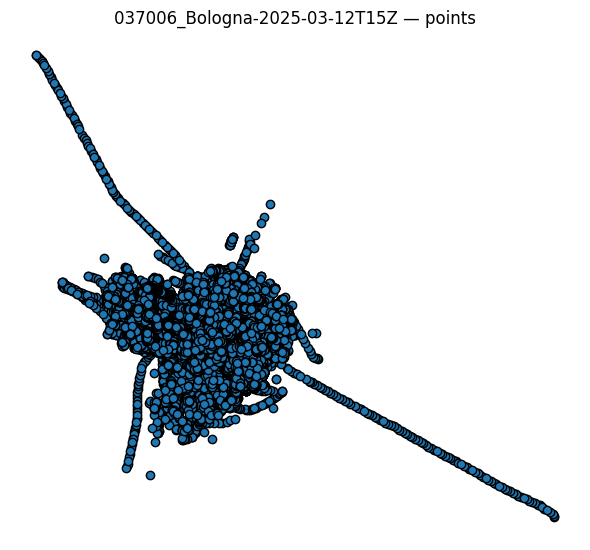



=== Layer: aree-ortive ===
Number of features: 21
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['denominazione_orto', 'indirizzo_orto', 'gestore_orto', 'indirizzo_gestore_orto', 'numero_orti', 'telefono_gestore', 'fax_gestore', 'mail_gestore', 'quartiere', 'lon', 'lat', 'nomezona', 'area_stati', 'geometry']
Missing values per column:
denominazione_orto         0
indirizzo_orto             0
gestore_orto               0
indirizzo_gestore_orto     0
numero_orti                0
telefono_gestore           6
fax_gestore               10
mail_gestore               1
quartiere                  0
lon                        0
lat                        0
nomezona                   0
area_stati                 0
geometry                   0
dtype: int64


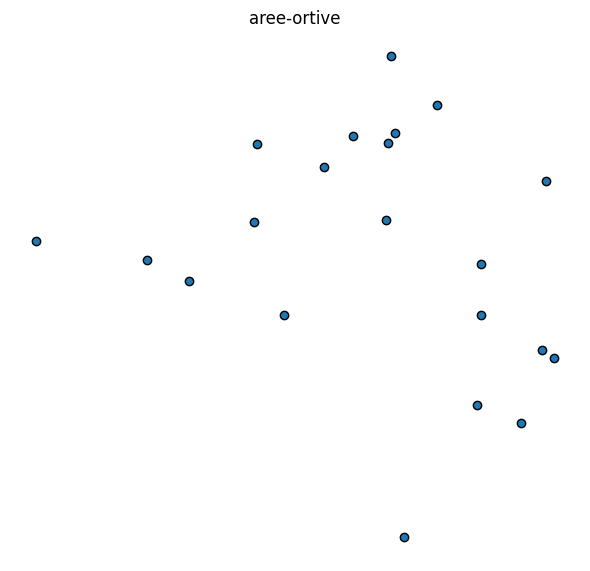



=== Layer: aree-statistiche ===
Number of features: 90
Geometry type: ['Polygon']
CRS: EPSG:4326
Columns: ['codice_area_statistica', 'geo_point_2d', 'area_statistica', 'cod_quar', 'quartiere', 'cod_zona', 'zona', 'geometry']
Missing values per column:
codice_area_statistica    0
geo_point_2d              0
area_statistica           0
cod_quar                  0
quartiere                 0
cod_zona                  0
zona                      0
geometry                  0
dtype: int64


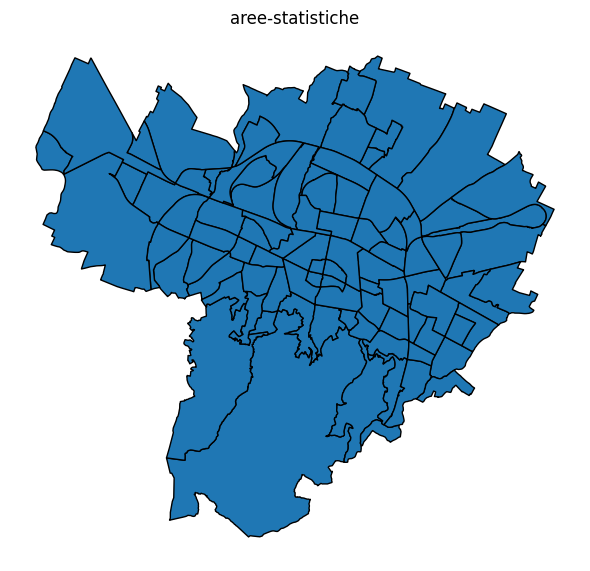



=== Layer: aree-verdi_entrate_centroidi ===
Number of features: 1200
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'tipo_di_area', 'nome', 'quartiere', 'ubicazione', 'geometry']
Missing values per column:
geo_point_2d      0
tipo_di_area    528
nome            528
quartiere       555
ubicazione      558
geometry          0
dtype: int64


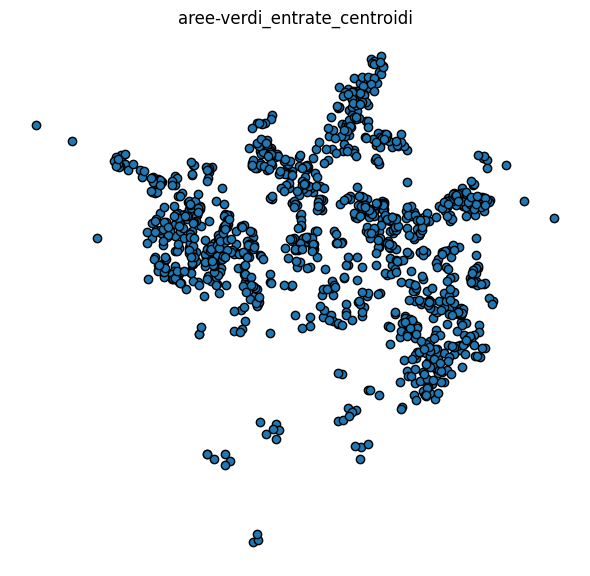



=== Layer: attrezzature_ludiche_ginniche_sportive ===
Number of features: 1414
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'categoria', 'classe', 'presenza', 'geometry']
Missing values per column:
geo_point_2d    0
categoria       1
classe          0
presenza        6
geometry        0
dtype: int64


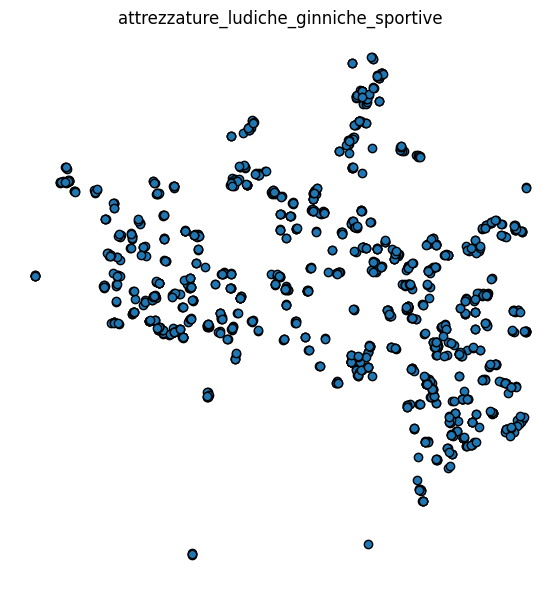



=== Layer: bagni-pubblici ===
Number of features: 30
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['tipologia', 'note', 'costo', 'posizione', 'geo_point_2d', 'descrizione', 'orari', 'accessibile', 'localizzazione', 'quartiere', 'sito_web', 'geo_id', 'sez_2011_istat', 'zona_fiu', 'area_stat', 'geometry']
Missing values per column:
tipologia          0
note              16
costo              0
posizione          0
geo_point_2d       0
descrizione        0
orari              0
accessibile        0
localizzazione     0
quartiere          0
sito_web          25
geo_id             0
sez_2011_istat     0
zona_fiu           0
area_stat          0
geometry           0
dtype: int64


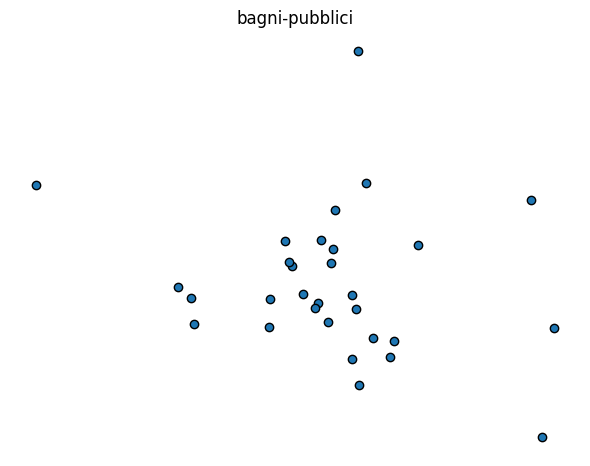



=== Layer: cammini-e-percorsi ===
Number of features: 2096
Geometry type: ['MultiLineString']
CRS: EPSG:4326
Columns: ['id', 'geo_point_2d', 'ascent', 'bicycle', 'colour', 'contact_we', 'descriptio', 'descript_1', 'descript_2', 'descript_3', 'destinatio', 'disused', 'duration', 'duration_b', 'duration_f', 'ele_from', 'ele_max', 'ele_min', 'ele_to', 'fixme', 'foot', 'from', 'from_ar', 'highway', 'name', 'name_it', 'network_ty', 'note_2', 'note_it', 'note_proje', 'operator', 'pilgrimage', 'ref_fie', 'ref_rei', 'reference', 'reg_ref', 'religion', 'roundtrip', 'sac_scale', 'source', 'symbol_it', 'to', 'tourism', 'via', 'visibility', 'website', 'wikidata', 'wikipedia', 'lunghezza', 'geometry']
Missing values per column:
id                 0
geo_point_2d       0
ascent           795
bicycle         2095
colour          2091
contact_we      2094
descriptio      1532
descript_1      2093
descript_2      1831
descript_3      2095
destinatio      2095
disused         2087
duration        2063


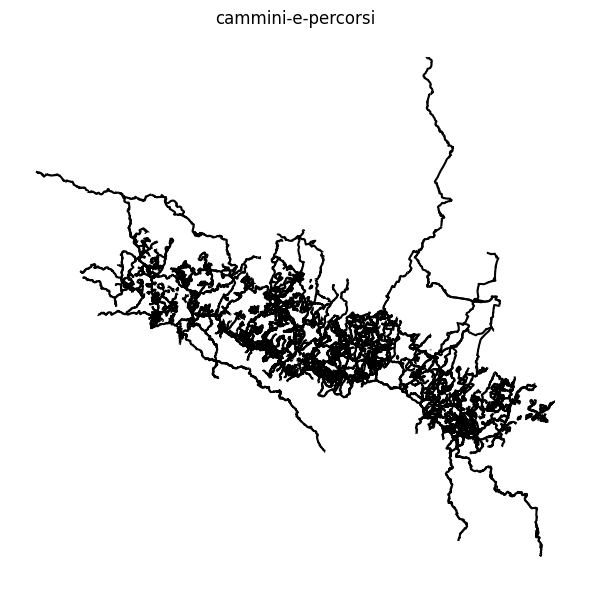



=== Layer: carta-tecnica-comunale-filari-siepi ===
Number of features: 8588
Geometry type: ['LineString']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'codice_ogg', 'data_istit', 'data_varia', 'lunghez', 'descrizion', 'origine', 'geometry']
Missing values per column:
geo_point_2d       0
codice_ogg         0
data_istit         0
data_varia      8502
lunghez            0
descrizion         0
origine            0
geometry           0
dtype: int64


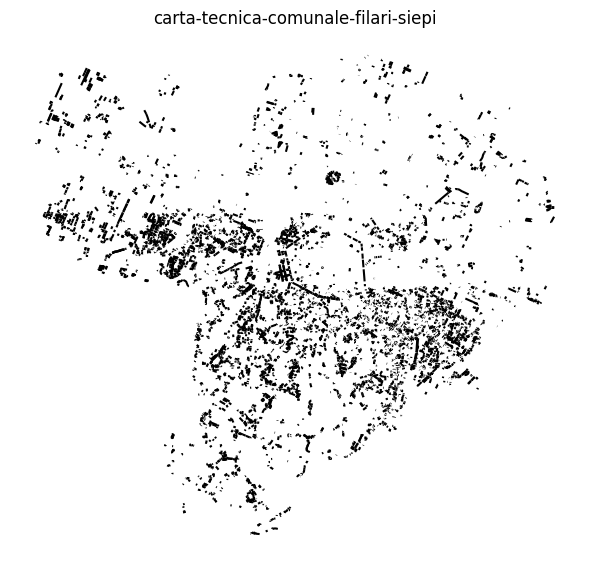



=== Layer: carta-tecnica-comunale-marciapiedi ===
Number of features: 13089
Geometry type: ['LineString']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'codice_ogg', 'data_istit', 'data_varia', 'lunghez', 'descrizion', 'origine', 'geometry']
Missing values per column:
geo_point_2d        0
codice_ogg          0
data_istit          0
data_varia      12274
lunghez             0
descrizion          0
origine             0
geometry            0
dtype: int64


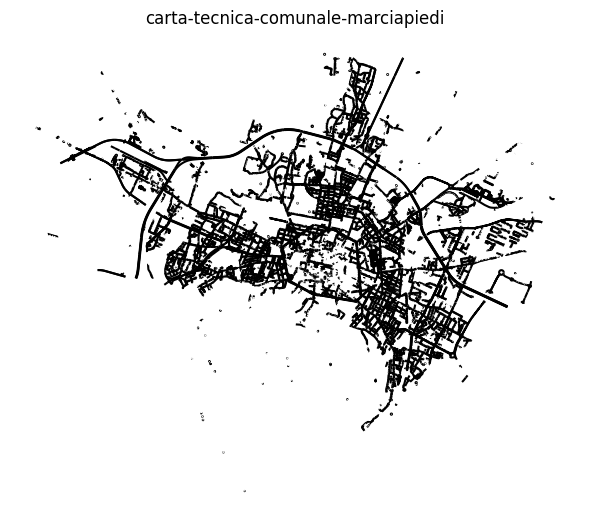



=== Layer: carta-tecnica-comunale-percorsi-pedonali ===
Number of features: 1379
Geometry type: ['LineString']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'codice_ogg', 'data_istit', 'data_varia', 'lunghez', 'descrizion', 'origine', 'geometry']
Missing values per column:
geo_point_2d       0
codice_ogg         0
data_istit         0
data_varia      1268
lunghez            0
descrizion         0
origine            0
geometry           0
dtype: int64


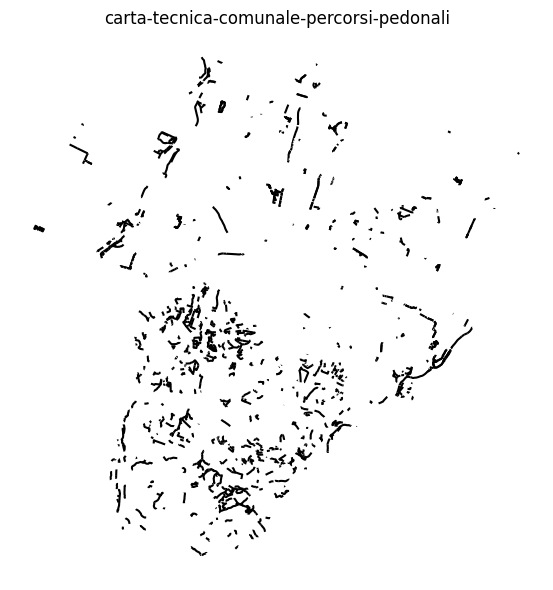



=== Layer: carta-tecnica-comunale-toponimi-parchi-e-giardini ===
Number of features: 252
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'codvia', 'nomevia', 'tipo', 'geometry']
Missing values per column:
geo_point_2d    0
codvia          0
nomevia         0
tipo            0
geometry        0
dtype: int64


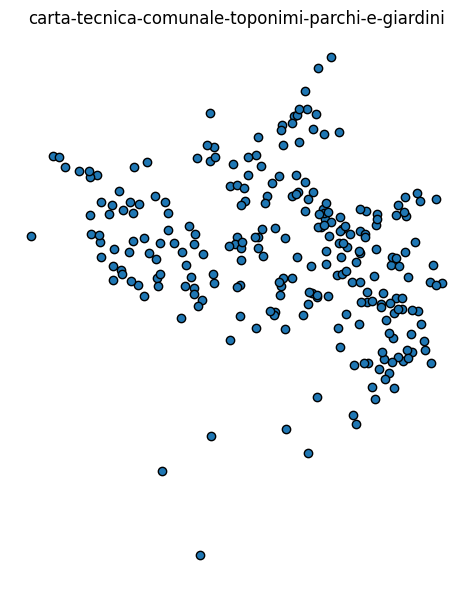



=== Layer: piste-ciclopedonali ===
Number of features: 1982
Geometry type: ['MultiLineString']
CRS: EPSG:4326
Columns: ['codice', 'anno', 'lunghezza', 'duso', 'dtipologia2', 'nomequart', 'geo_point_2d', 'zona_fiu', 'length', 'tipologia2', 'geometry']
Missing values per column:
codice           0
anno             0
lunghezza        0
duso             0
dtipologia2     22
nomequart        0
geo_point_2d     0
zona_fiu         0
length           0
tipologia2      22
geometry         0
dtype: int64


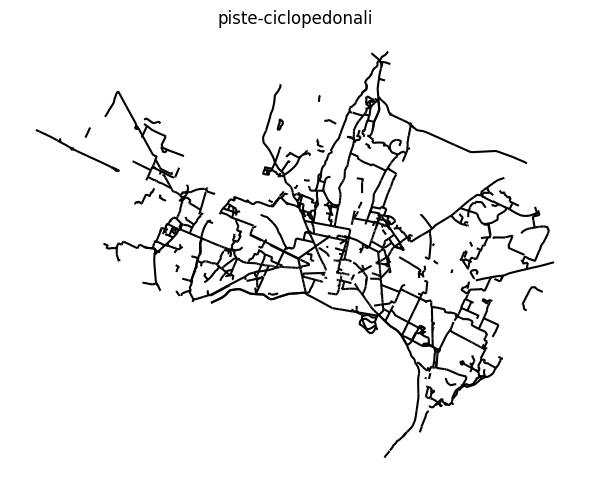



=== Layer: popolazione-arborea ===
Number of features: 9113
Geometry type: ['MultiPolygon']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'geo_shape', 'pop_area', 'classe_popolamento', 'classe_origine', 'classe_dimora', 'classe', 'data_agg', 'in_patrim', 'classe_struttura', 'classe_circonferenza_diametro', 'classe_altezza', 'geometry']
Missing values per column:
geo_point_2d                        0
geo_shape                        9113
pop_area                            0
classe_popolamento                  4
classe_origine                     15
classe_dimora                     242
classe                            109
data_agg                         1153
in_patrim                          25
classe_struttura                  101
classe_circonferenza_diametro     723
classe_altezza                     86
geometry                            0
dtype: int64


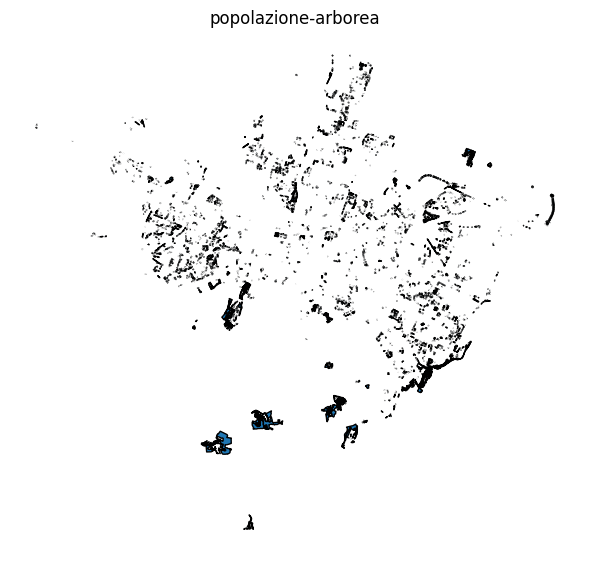



=== Layer: portici ===
Number of features: 12
Geometry type: ['MultiPolygon']
CRS: EPSG:4326
Columns: ['id', 'titolo', 'testo', 'immagine_principale', 'videoguida_is', 'videoguida_lis', 'poi_id', 'url', 'coordinate', 'geometry']
Missing values per column:
id                      0
titolo                  0
testo                   0
immagine_principale     0
videoguida_is          12
videoguida_lis          0
poi_id                  0
url                     0
coordinate              0
geometry                0
dtype: int64


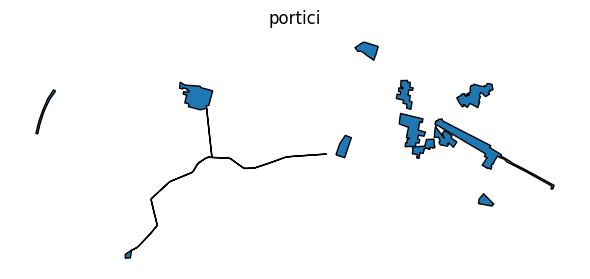



=== Layer: rastrelliere-per-biciclette ===
Number of features: 755
Geometry type: ['Point']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'id', 'nomevia', 'civico', 'numposti', 'geometry']
Missing values per column:
geo_point_2d      0
id                0
nomevia           0
civico          162
numposti          0
geometry          0
dtype: int64


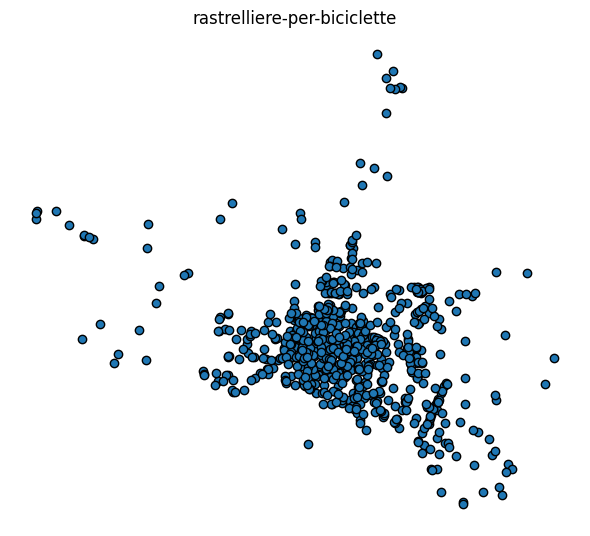



=== Layer: verde_privato_urbanizzato ===
Number of features: 25529
Geometry type: ['Polygon']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'codice_ogg', 'centro_sto', 'quartiere', 'patrimonio', 'note', 'area_ogg', 'geometry']
Missing values per column:
geo_point_2d        0
codice_ogg          0
centro_sto          0
quartiere           0
patrimonio          0
note            23521
area_ogg            0
geometry            0
dtype: int64


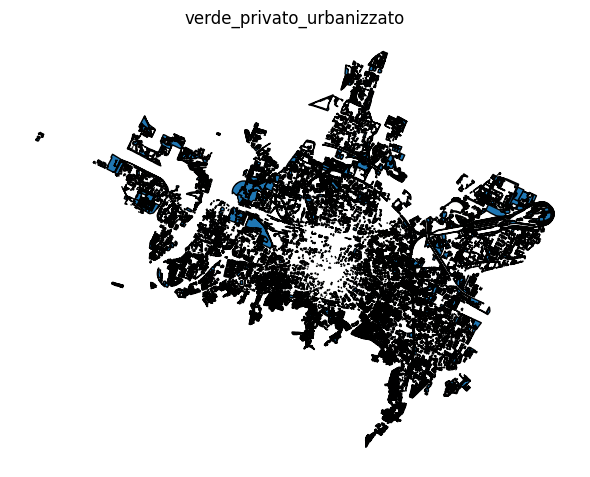



=== Layer: zona-pedonale-centro-storico ===
Number of features: 62
Geometry type: ['MultiPolygon']
CRS: EPSG:4326
Columns: ['geo_point_2d', 'ente', 'codice', 'ordinanza', 'stato', 'area', 'codarco1', 'nomevia1', 'codarco2', 'nomevia2', 'codarco3', 'nomevia3', 'codarco4', 'nomevia4', 'codarco5', 'nomevia5', 'codarco6', 'nomevia6', 'codarco7', 'nomevia7', 'iidd', 'tipoztl', 'geometry']
Missing values per column:
geo_point_2d     0
ente            62
codice          21
ordinanza        9
stato            8
area             8
codarco1        22
nomevia1        12
codarco2        37
nomevia2        36
codarco3        41
nomevia3        41
codarco4        49
nomevia4        49
codarco5        50
nomevia5        50
codarco6        55
nomevia6        55
codarco7        57
nomevia7        57
iidd            29
tipoztl          0
geometry         0
dtype: int64


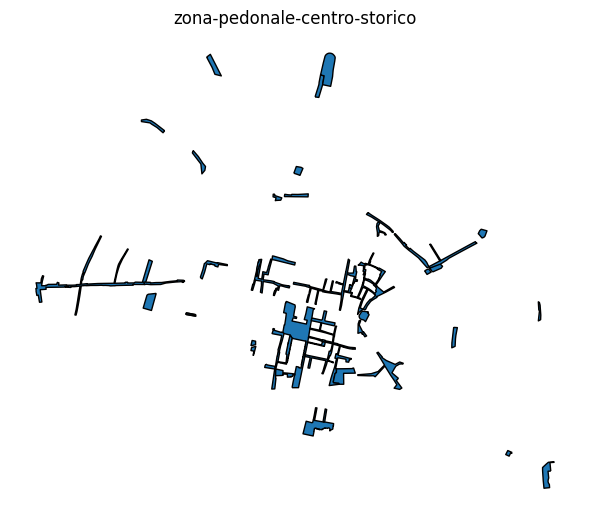



=== Layer: layer_styles ===
Non-spatial layer. Skipping plot.




In [3]:
print(f"Found {len(layers)} layers.\n")

# Loop through each layer
for layer_name in layers:
    print(f"=== Layer: {layer_name} ===")
    
    try:
        gdf = gpd.read_file(gpkg_path, layer=layer_name)

        # Check if it's a GeoDataFrame with geometries
        if not gdf.empty and 'geometry' in gdf.columns:
            print(f"Number of features: {len(gdf)}")
            print(f"Geometry type: {gdf.geom_type.unique()}")
            print(f"CRS: {gdf.crs}")
            print("Columns:", list(gdf.columns))
            print("Missing values per column:")
            print(gdf.isnull().sum())

            gdf.plot(figsize=(6, 6), edgecolor='black')
            plt.title(f"{layer_name}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.close()
        else:
            print("Non-spatial layer. Skipping plot.")

        print("\n")

    except Exception as e:
        print(f"Failed to process {layer_name}: {e}")
        continue

In [4]:
summary_data = []

for layer_name in layers:
    try:
        gdf = gpd.read_file(gpkg_path, layer=layer_name)
        
        if 'geometry' not in gdf.columns:
            continue  # Skip non-spatial

        geom_types = gdf.geom_type.unique()
        num_features = len(gdf)
        crs = gdf.crs
        columns = list(gdf.columns)
        missing_data = gdf.isnull().mean() * 100 

        summary_data.append({
            "Layer": layer_name,
            "Geometry Types": ", ".join(geom_types),
            "Features": num_features,
            "CRS": crs.to_string() if crs else None,
            "Columns": columns,
            "Missing % (avg)": round(missing_data.mean(), 2)
        })

    except Exception as e:
        print(f"Error with layer {layer_name}: {e}")

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("Data/summary_layers.csv", index=False)
        

## Clustering

In [5]:
# Layer per thematic groups
theme_layers = {
    "OSM base": [
        "037006_Bologna-2025-03-12T15Z — lines",
        "037006_Bologna-2025-03-12T15Z — multilinestrings",
        "037006_Bologna-2025-03-12T15Z — multipolygons",
        "037006_Bologna-2025-03-12T15Z — points",
        "037006_Bologna-2025-03-12T15Z — other_relations"
    ],
    "Mobility": [
        "piste-ciclopedonali",
        "rastrelliere-per-biciclette",
        "cammini-e-percorsi",
        "zona-pedonale-centro-storico"
    ],
    "Green areas": [
        "aree-verdi_entrate_centroidi",
        "popolazione-arborea",
        "verde_privato_urbanizzato",
        "aree-ortive"
    ],
    "Services": [
        "bagni-pubblici",
        "attrezzature_ludiche_ginniche_sportive",
        "portici"
    ],
    "Technical info": [
        "aree-statistiche",
        "carta-tecnica-comunale-filari-siepi",
        "carta-tecnica-comunale-marciapiedi",
        "carta-tecnica-comunale-percorsi-pedonali",
        "carta-tecnica-comunale-toponimi-parchi-e-giardini"
    ]
}

all_summary = []

# Analysis of thematic groups
for group, layer_list in theme_layers.items():
    print(f"\nAnalysis of group: {group}")
    
    for layer_name in layer_list:
        try:
            gdf = gpd.read_file(gpkg_path, layer=layer_name)

            if 'geometry' not in gdf.columns:
                continue

            summary = {
                "Group": group,
                "Layer": layer_name,
                "Geometry": ", ".join(gdf.geom_type.unique()),
                "CRS": gdf.crs.to_string() if gdf.crs else "None",
                "N° features": len(gdf),
                "Columns": list(gdf.columns),
                "Missing %": round(gdf.isnull().mean().mean() * 100, 2)
            }
            all_summary.append(summary)

            print(f"{layer_name}: {summary['N° features']} feature, geom: {summary['Geometry']}")

        except Exception as e:
            print(f"Error on {layer_name}: {e}")

summary_df = pd.DataFrame(all_summary)
summary_df.to_csv("Data/summary_groups.csv", index=False)



Analysis of group: OSM base
037006_Bologna-2025-03-12T15Z — lines: 36734 feature, geom: LineString
037006_Bologna-2025-03-12T15Z — multilinestrings: 509 feature, geom: MultiLineString
037006_Bologna-2025-03-12T15Z — multipolygons: 62007 feature, geom: MultiPolygon
037006_Bologna-2025-03-12T15Z — points: 171737 feature, geom: Point
037006_Bologna-2025-03-12T15Z — other_relations: 1504 feature, geom: GeometryCollection

Analysis of group: Mobility
piste-ciclopedonali: 1982 feature, geom: MultiLineString
rastrelliere-per-biciclette: 755 feature, geom: Point
cammini-e-percorsi: 2096 feature, geom: MultiLineString
zona-pedonale-centro-storico: 62 feature, geom: MultiPolygon

Analysis of group: Green areas
aree-verdi_entrate_centroidi: 1200 feature, geom: Point
popolazione-arborea: 9113 feature, geom: MultiPolygon
verde_privato_urbanizzato: 25529 feature, geom: Polygon
aree-ortive: 21 feature, geom: Point

Analysis of group: Services
bagni-pubblici: 30 feature, geom: Point
attrezzature_ludi

## Create interactive map

In [6]:
m = folium.Map(location=[44.4949, 11.3426], zoom_start=13, tiles=None)

layers_OSM = [
    "037006_Bologna-2025-03-12T15Z — lines",
    "037006_Bologna-2025-03-12T15Z — multilinestrings",
    "037006_Bologna-2025-03-12T15Z — multipolygons",
    "037006_Bologna-2025-03-12T15Z — points",
    "037006_Bologna-2025-03-12T15Z — other_relations"
]

layers_map = set(layers) - set(layers_OSM)

for layer_name in layers:
    try:
        gdf = gpd.read_file(gpkg_path, layer=layer_name)

        if gdf.empty or 'geometry' not in gdf.columns:
            continue

        # Convert datetime columns to strings to make them JSON serializable
        for col in gdf.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
            gdf[col] = gdf[col].astype(str)

        if layer_name in layers_OSM:
            folium.TileLayer('OpenStreetMap').add_to(m)
            continue

        fg = folium.FeatureGroup(name=layer_name, show=False)

        popup_fields = [col for col in gdf.columns if col != 'geometry' and not col.lower().endswith('id')]

        folium.GeoJson(
            gdf,
            name=layer_name,
            popup=folium.GeoJsonPopup(fields=popup_fields),
            tooltip=folium.GeoJsonTooltip(
                fields=popup_fields,
                aliases=[f"{f}: " for f in popup_fields],
                localize=True,
                sticky=True,
                labels=True,
                style="background-color: white; border: 1px solid black; padding: 5px;"
            )
        ).add_to(fg)

        fg.add_to(m)

    except Exception as e:
        print(f"Error with layer {layer_name}: {e}")

folium.LayerControl(collapsed=False).add_to(m)
m.save("maps/bologna_interactive_map.html")

In [7]:
zip_path = "maps/bologna_interactive_map.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(zip_path, arcname="bologna_interactive_map.html")


# Optimization Problem

We then proceed with the set up the optimization problem. 

First, the working area is restricted to the city center of Bologna.
Successively, we define a grid of cells 100x100m and try to optimize its placement, aiming to maximize the total score obtained by the grid. 

As stated before, the score is based on how many elements are covered by a cell and also which particular elements are present, because weighting is applied. 

To optimize the placement of the grid we define two ranges of offsets (one horizontal and one vertical) and one of angles of rotation.
These represent the paramenters of the problem, which define the placement of the grid and which we want to optimize aiming to maximize the total score of the grid.

This allows us to obtain a good starting point for placing the green cells.

Finally, only the most proficient cells are selected for the placement of the green cells, and this is done by selecting only the top 10% cells with the maximum score.

## Restricting the working area

The area is restricted to the city center of Bologna and each layer is visualized after reprojection.

In [8]:
# Restricting the working area to the center of Bologna 

# Using the "aree-statistiche" layer to define the area of interest
aree_statistiche = gpd.read_file(gpkg_path, layer="aree-statistiche")

working_area = aree_statistiche[
    aree_statistiche["area_statistica"].isin(["MALPIGHI-1", "IRNERIO-1", "GALVANI-1", "MARCONI-1", "MALPIGHI-2", "IRNERIO-2", "GALVANI-2", "MARCONI-2"])
].copy()

working_geom = unary_union(working_area.geometry)

working_layers = [layer for layer in fiona.listlayers(gpkg_path) 
          if layer not in ["layer_styles", "other_relations"]]

# Clip each layer to the working area
clipped_layers = {}
output_gpkg = "Data/city_center.gpkg"


for layer in working_layers:
    gdf = gpd.read_file(gpkg_path, layer=layer)

    if gdf.crs is None:
        print(f"Layer '{layer}' has no CRS defined. Skipping.")
        continue  

    gdf = gdf.to_crs(working_area.crs)
    gdf = gdf[gdf.is_valid]

    try:
        gdf_clipped = gpd.clip(gdf, working_geom)
    except Exception as e:
        print(f"Error in clipping layer {layer}: {e}")
        continue

    clipped_layers[layer] = gdf_clipped

    if not gdf_clipped.empty:
        gdf_clipped.to_file(output_gpkg, layer=layer, driver="GPKG")
    else:
        print(f"Layer '{layer}' empty after clip. Skippong.")

Layer '037006_Bologna-2025-03-12T15Z — other_relations' has no CRS defined. Skipping.
Layer 'aree-ortive' empty after clip. Skippong.


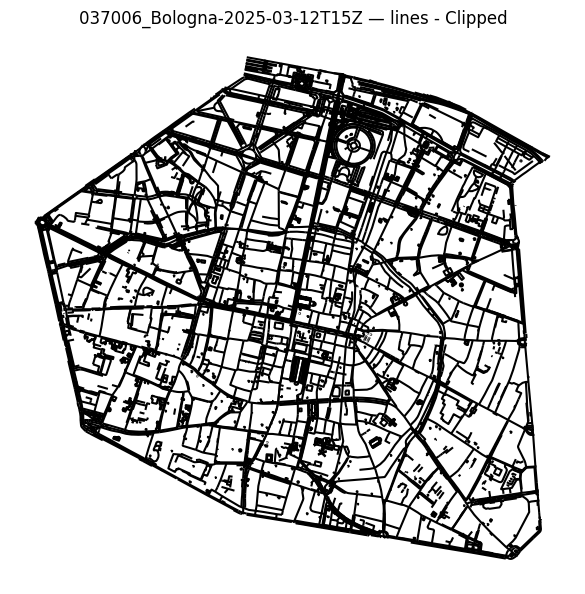

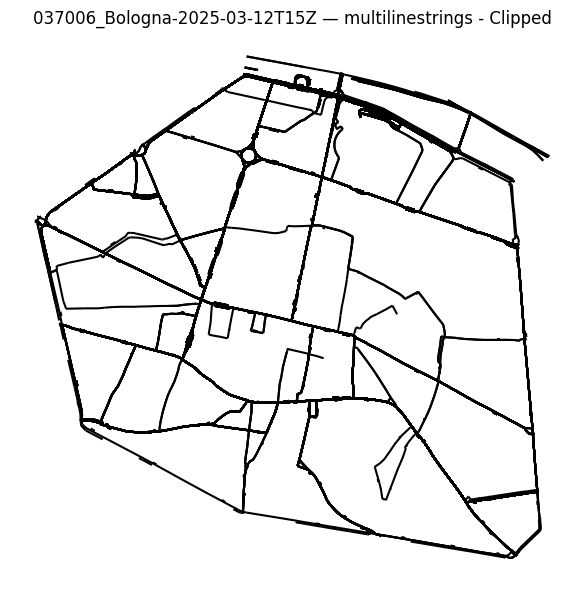

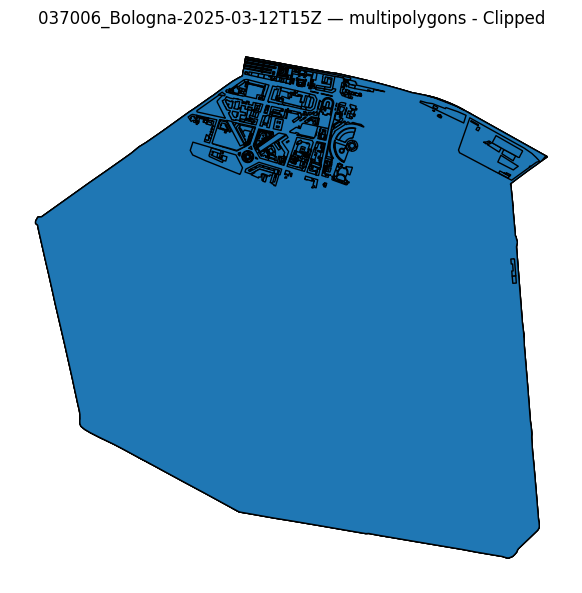

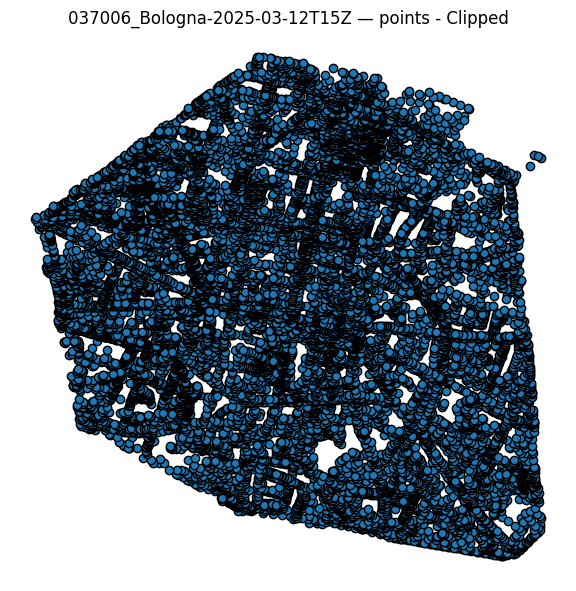

Layer 'aree-ortive' empty.


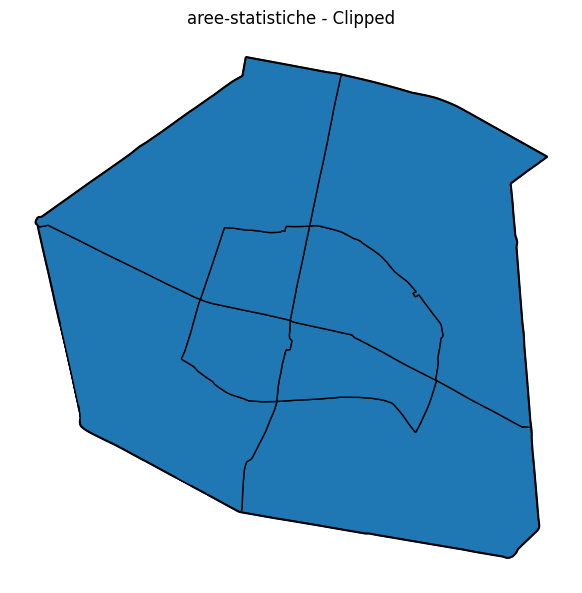

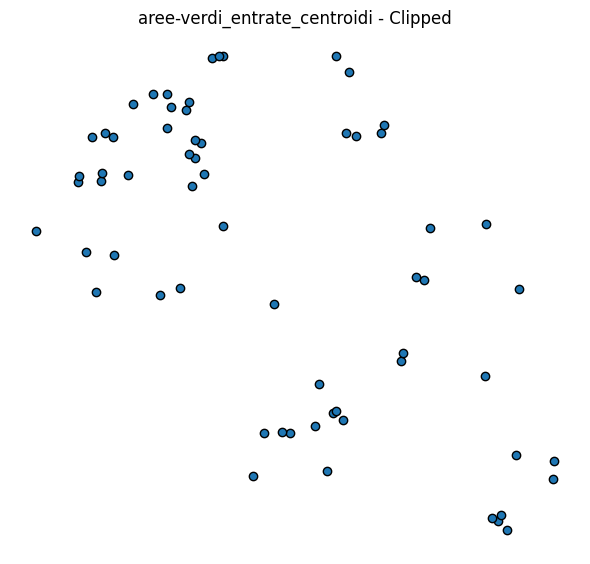

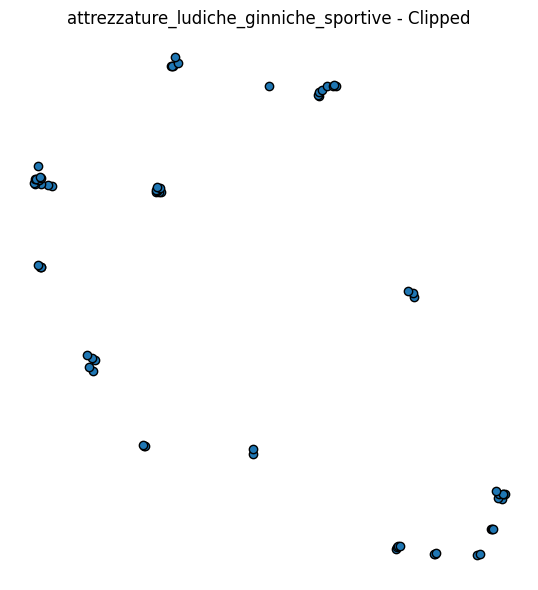

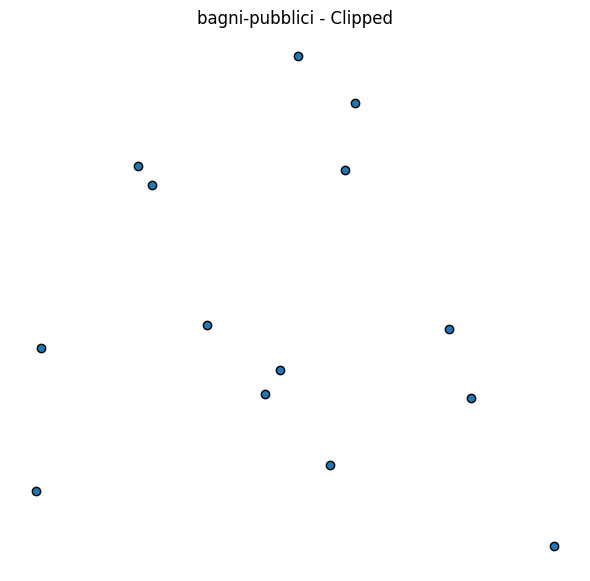

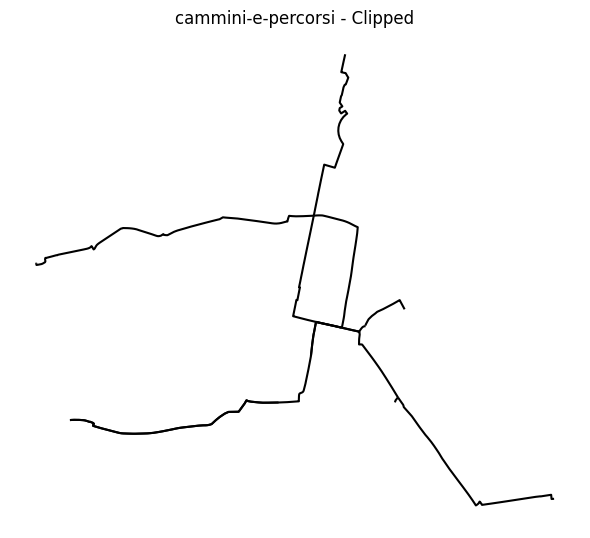

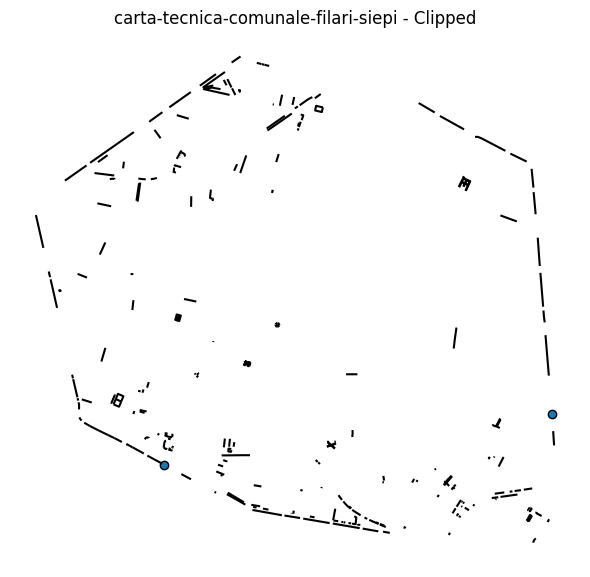

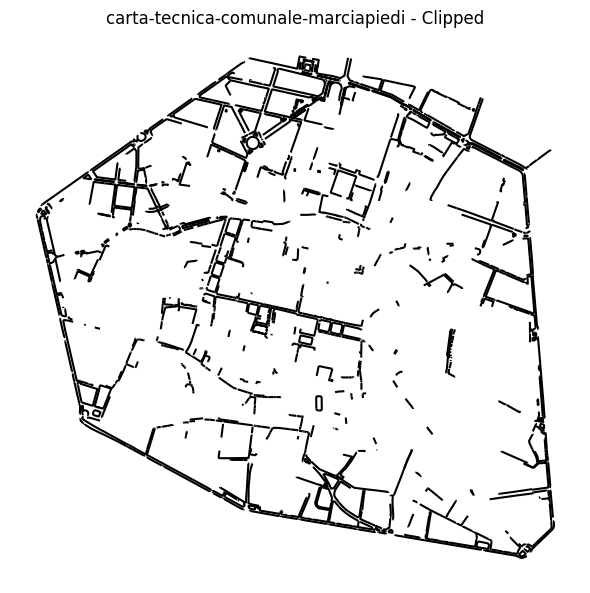

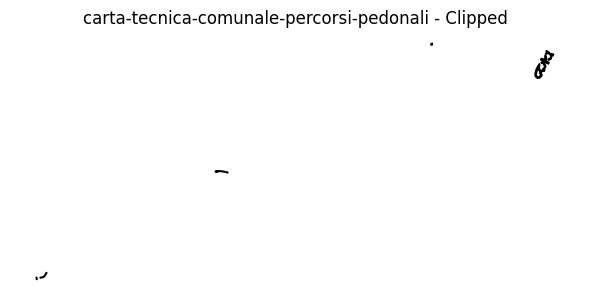

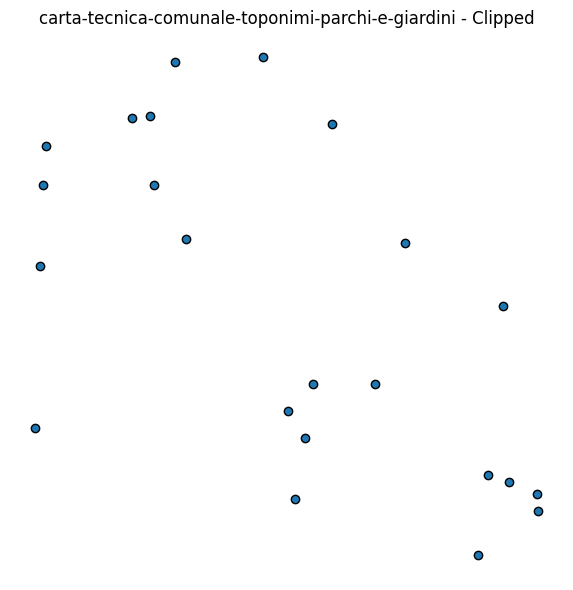

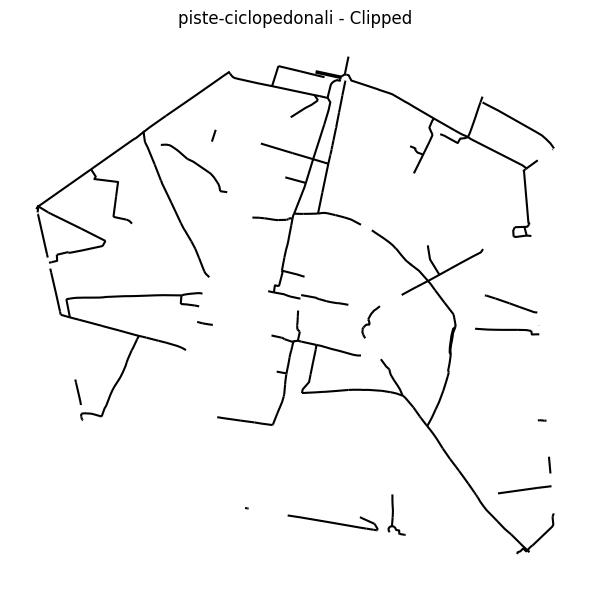

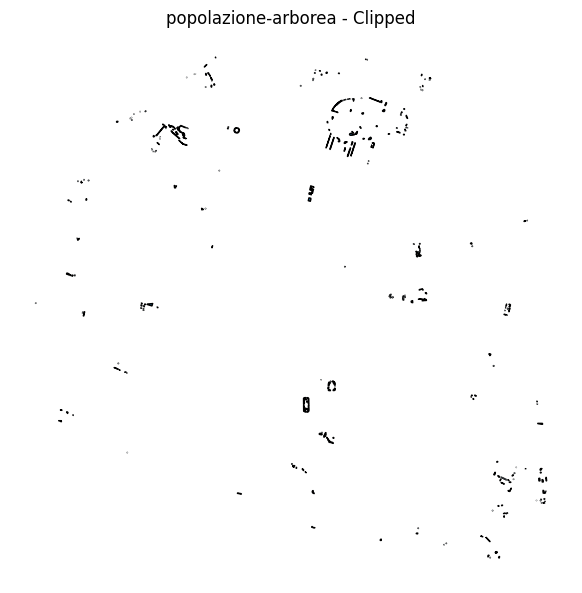

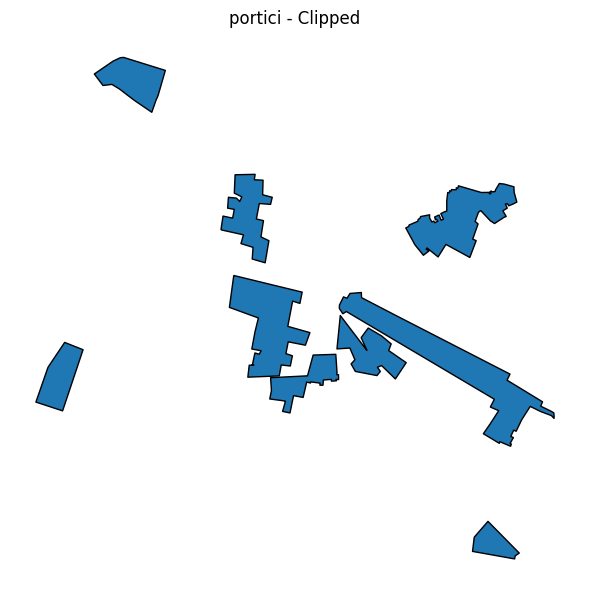

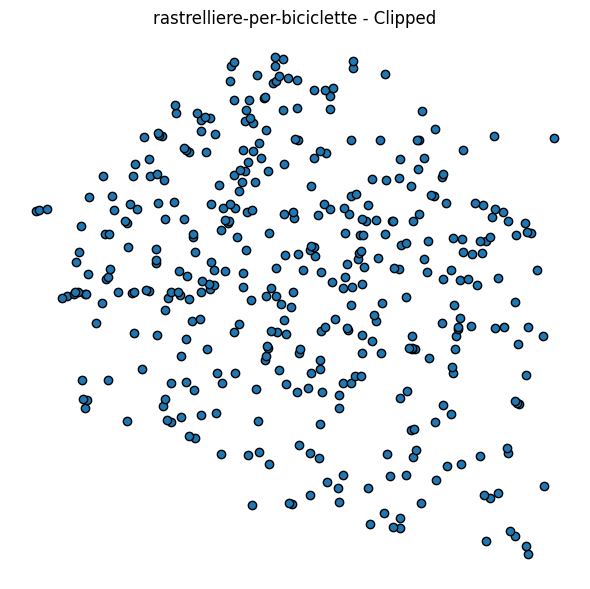

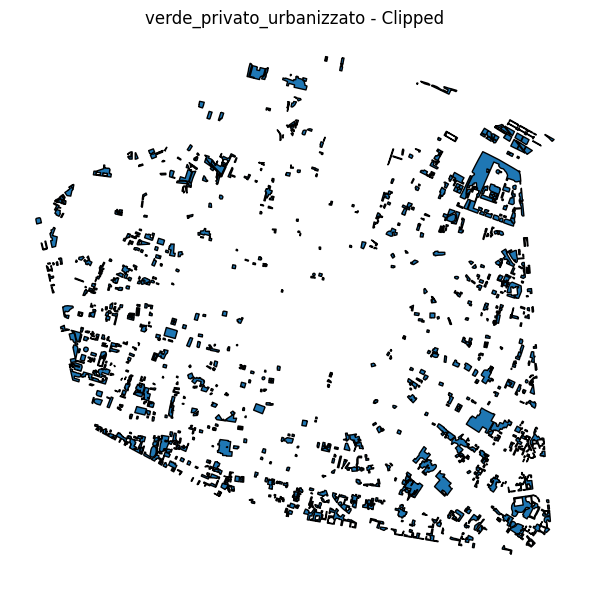

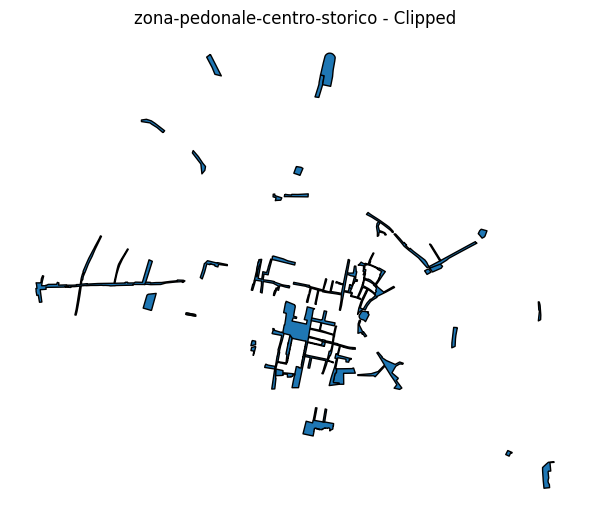

In [9]:
# Visualize the clipped layers
for layer_name, gdf in clipped_layers.items():
    if not gdf.empty and 'geometry' in gdf.columns:
        gdf.plot(figsize=(6, 6), edgecolor='black')
        plt.title(f"{layer_name} - Clipped")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print(f"Layer '{layer_name}' empty.")

## Grid Creation and Visualization

A fucntion is defined to create a grid, given a reference GeoDataFrame (representing a geographic area), the cell size, horizontal and vertical offset and rotation.

Then, a first example grid for the center of bologna is visualized.

In [10]:
def create_grid(city_center_df, cell_size=100, offset_x=0, offset_y=0, rotazione=0):
    # Bounding box originale
    minx, miny, maxx, maxy = city_center_df.total_bounds
    crs = city_center_df.crs

    # Apply offset
    minx += offset_x
    maxx += offset_x
    miny += offset_y
    maxy += offset_y

    # Bounding box center
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Original bounding box
    bbox = box(minx, miny, maxx, maxy)

    # Rotate the bounding box around its center to get the maximum area of the grid
    bbox_rotated_back = rotate(bbox, angle=-rotazione, origin=(center_x, center_y), use_radians=False)

    # Get the bounds of the rotated bounding box
    minx_rot, miny_rot, maxx_rot, maxy_rot = bbox_rotated_back.bounds

    padding = cell_size 
    # Add padding to the bounding box to ensure grid cells are not cut off
    minx_rot -= padding
    maxx_rot += padding
    miny_rot -= padding
    maxy_rot += padding

    # Create grid cells
    x_coords = np.arange(minx_rot, maxx_rot, cell_size)
    y_coords = np.arange(miny_rot, maxy_rot, cell_size)

    grid_cells = []
    for x in x_coords:
        for y in y_coords:
            grid_cells.append(box(x, y, x + cell_size, y + cell_size))

    # Rotate the grid cells back to the original orientation
    rotated_cells = [rotate(c, angle=rotazione, origin=(center_x, center_y), use_radians=False)
                     for c in grid_cells]

    # Crea GeoDataFrame
    grid = gpd.GeoDataFrame({'geometry': rotated_cells}, crs=crs)
    return grid

In [11]:
# Creation of the example global grid

city_center_df = gpd.read_file(output_gpkg, layer="aree-statistiche")

# Check the CRS
print("Original CRS:", city_center_df.crs)

# If the CRS is geographic, estimate and transform to UTM
if city_center_df.crs.is_geographic:
    utm_crs = city_center_df.estimate_utm_crs()
    city_center_df = city_center_df.to_crs(utm_crs)
    print("CRS converted in UTM:", city_center_df.crs)


# Set parameters for the grid
offset_x = 0  # Offset (meters) along the X-axis
offset_y = 0  # Offset (meters) along the Y-axis
rotazione = 0  # Rotation angle in degrees (0 for no rotation)
cell_size = 100  # Size of each grid cell in meters (100x100 m)

grid = create_grid(city_center_df, cell_size, offset_x, offset_y, rotazione)

grid_size = len(grid)
print(f"Created grid with {grid_size} cells (100x100 m)")

Original CRS: EPSG:4326
CRS converted in UTM: EPSG:32632
Created grid with 756 cells (100x100 m)


CRS converted to UTM: EPSG:32632


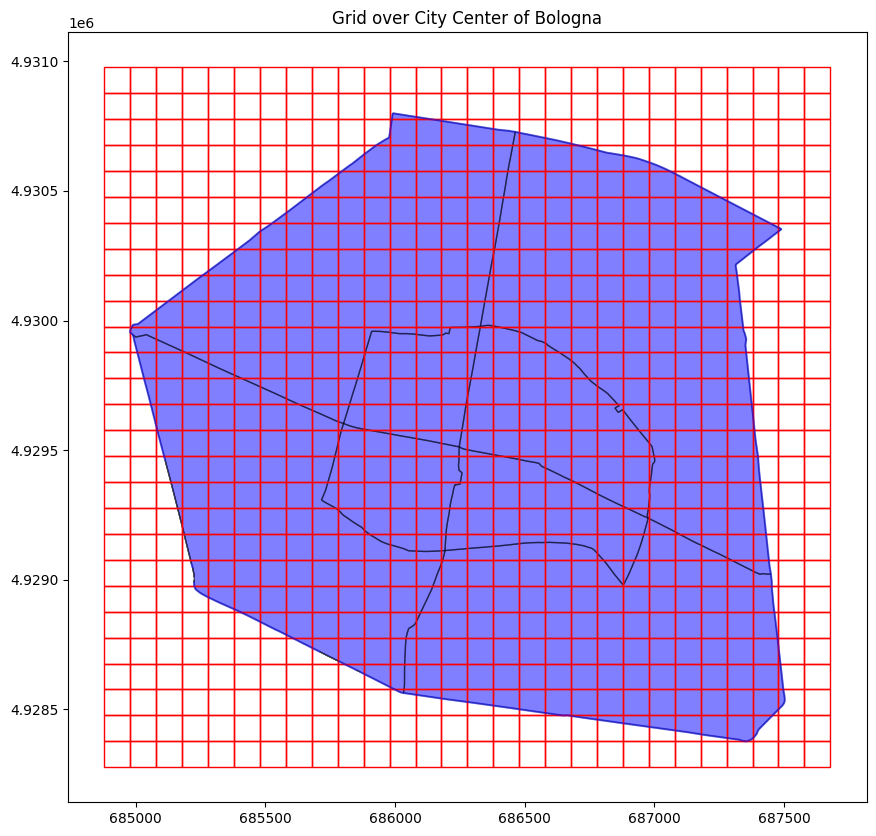

In [12]:
# Visualize grid over city center
city_center_df = gpd.read_file(output_gpkg, layer="aree-statistiche")

if city_center_df.crs.is_geographic:
    utm_crs = city_center_df.estimate_utm_crs()
    city_center_df = city_center_df.to_crs(utm_crs)
    print("CRS converted to UTM:", city_center_df.crs)

ax = city_center_df.plot(color='blue', alpha=0.5, edgecolor='k', figsize=(12,10))
grid.plot(ax=ax, facecolor='none', edgecolor='red')

plt.title("Grid over City Center of Bologna")
plt.show()

## Cells Analysis: coverage and scoring

A cell is considered a good cell if it contains many elements that we consider good for the placement of green cells. Hence, we defined a list of good elements for a cell, with a weight point associated, as well as a function to calculate the coverage of the cell wrt these elements. 

This was then used as base to calculate how good a cell can be, given the coverage percentage of good architectural elements and how good they're considered.

The following weights were assigned:

- High (0.8), for elements we consider very good to have close to the green cell we want to place: bicycle and pedestrian paths, pedestrian zones, porches (portici di Bologna), sidewalks, parks and green areas

- Medium (0.50) for elements we consider potentially useful for the placement of a cell: bike racks, private green areas, hedgerows, trees, gardens

- Low (0.20) for elements which are not fundamental for new green areas but still they're good to have: public toilets and sports-ludic-gymnastic equipments.

This part can be adjusted an tuned as needed.

### Evaluation Functions

In [13]:
# bonus_layers are all but: "other_relations", "layer_styles" and OSM layer (because we took into account only the positive elements)
bonus_layers = [
    "piste-ciclopedonali",
    "rastrelliere-per-biciclette",
    "cammini-e-percorsi",
    "zona-pedonale-centro-storico",
    "aree-verdi_entrate_centroidi",
    "popolazione-arborea",
    "verde_privato_urbanizzato",
    "aree-ortive",
    "bagni-pubblici",
    "attrezzature_ludiche_ginniche_sportive",
    "portici"
    "carta-tecnica-comunale-filari-siepi",
    "carta-tecnica-comunale-marciapiedi",
    "carta-tecnica-comunale-percorsi-pedonali",
    "carta-tecnica-comunale-toponimi-parchi-e-giardini"
]
#############################
Bonus= {
    "high": [
        "piste-ciclopedonali",
        "cammini-e-percorsi",
        "zona-pedonale-centro-storico",
        "portici",
        "carta-tecnica-comunale-marciapiedi",
        "carta-tecnica-comunale-percorsi-pedonali",
        "carta-tecnica-comunale-toponimi-parchi-e-giardini",
        "aree-verdi_entrate_centroidi",
    ],
    "medium": [
        "rastrelliere-per-biciclette",
        "verde_privato_urbanizzato",
        "carta-tecnica-comunale-filari-siepi",
        "aree-ortive",
        "popolazione-arborea",
    ],
    "low": [
        "bagni-pubblici",
        "attrezzature_ludiche_ginniche_sportive",
    ],
}

bonus_weights = {
    "high": 0.8,
    "medium": 0.5,
    "low": 0.2
}

layer_scores = {
    layer: bonus_weights[category]
    for category, layers in Bonus.items()
    for layer in layers
}
# format of layer_scores: 
# "piste-ciclopedonali": 0.8, "rastrelliere-per-biciclette": 0.5, ...

# Load all layers into a dictionary of GeoDataFrames
layer_gdfs = {
    name: gpd.read_file(output_gpkg, layer=name).to_crs("EPSG:32632")
    for name in layer_scores
}

results = pd.DataFrame(columns=["Box", "Copertura", "Valutazione", "Dettagli"])

In [14]:
# Function to calculate coverage percentage of a cell against a layer
# Divides the cell into 1m x 1m squares and checks how many of them intersect with the layer
def coverage_percentage(cell, layer, cell_size=100):
    minx, miny, maxx, maxy = cell.bounds
    
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    
    cell_1m = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]
    
    grid_1m = gpd.GeoDataFrame({'geometry': cell_1m}, crs=layer.crs)
    
    layer_bounds = layer.total_bounds
    bbox = box(*layer_bounds)
    
    if not cell.intersects(bbox):
        return 0.0
    
    candidate_cell = grid_1m[grid_1m.intersects(bbox)].copy()
    
    joined = gpd.sjoin(candidate_cell, layer, how="inner", predicate='intersects')
    
    if joined.empty:
        n_intersect = 0
    else:
        n_intersect = joined['index_left'].nunique() if 'index_left' in joined.columns else joined.index.nunique()
    
    total_cells_1m = len(grid_1m)
    
    percent = (n_intersect / total_cells_1m) * 100
    
    return percent

In [15]:
# # -------------------------------- COVERAGE PERCENTAGE ALTERNATIVE (faster but more invariant to lines and points that have very small dimension) --------------------------------
# def coverage_percentage(cell, layer):
#     if layer.empty or not cell.intersects(layer.unary_union):
#         return 0.0

#     # Poligoni → % di area coperta
#     if layer.geom_type.iloc[0] in ['Polygon', 'MultiPolygon']:
#         inter = layer.intersection(cell)
#         area_inter = inter.area.sum()
#         return (area_inter / cell.area) * 100

#     # Linee → % di lunghezza nella cella rispetto a una lunghezza massima ipotetica
#     elif layer.geom_type.iloc[0] in ['LineString', 'MultiLineString']:
#         inter = layer.intersection(cell)
#         length_in_cell = inter.length.sum()
#         max_length = 4 * (cell.length / 2)  # per una cella quadrata = perimetro
#         return min((length_in_cell / max_length) * 100, 100)

#     # Punti → % rispetto a un numero massimo stimato di punti per cella (es. 10)
#     elif layer.geom_type.iloc[0] == 'Point':
#         n_points = layer[layer.intersects(cell)].shape[0]
#         max_points = 10
#         return min((n_points / max_points) * 100, 100)

#     else:
#         print(f"Geometria non gestita: {layer.geom_type.iloc[0]}")
#         return 0.0


In [16]:
def evaluate_cell(cell, layer_scores, layer_gdfs, show_map=False):
    details = []
    total_score = 0.0
    total_coverage_percentage = 0.0

    for layer_name, peso in layer_scores.items():
        gdf = layer_gdfs.get(layer_name)
        
        if gdf.empty:
            continue

        coverage = coverage_percentage(cell, gdf)
        partial_score = (coverage/ 100.0) * peso * 10000  # 10000 m² is the area of a 100x100 m cell
        details.append((layer_name, coverage, partial_score))
        total_score += partial_score
        total_coverage_percentage += coverage
        
    if show_map and total_score > 0:
        gdf_cella = gpd.GeoDataFrame(geometry=[cell], crs="EPSG:32632")
        fig, ax = plt.subplots(figsize=(12, 12))

        color_map = {} 

        for i, layer_name in enumerate(layer_scores.keys()):
            try:
                gdf = layer_gdfs[layer_name] # Use the preloaded dictionary
                if not gdf.empty:
                    color = plt.cm.tab20(i % 20)  # Use a colormap for distinct colors
                    gdf.plot(ax=ax, color=color, alpha=0.4, label=layer_name)
                    color_map[layer_name] = color
            except Exception as e:
                print(f"Error in layer {layer_name}: {e}")
                continue

        # Plot 
        gdf_cella.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label="Cell 100x100")

        plt.title("Cell + Overlayed Layers")
        plt.legend(loc='upper left', fontsize='small')
        plt.axis('equal')
        plt.show()

        print(f"\nTotal score: {total_score:.3f}\nTotal coverage: {total_coverage_percentage:.1f}%\n")
        print("Details (per layer):")
        for nome, perc, parziale in details:
            print(f"- {nome}: {perc:.1f}% covered → score: {parziale:.3f}")
    
    return total_score, total_coverage_percentage, details


### Cells Evaluation Example

An example of the evaluation of the cells of a grid.

The score of a grid is the sum of the single scores of the cells.

Evaluation also includes coverage percentage, details of the covered layers and an explanation of the score composition, as can bee seen in the next output block (each row contains: coordinates of the cell, coverage of architectural elements, associated score, explanation of the score (per layer coverage percentage and score breakdown))

In [17]:
records = []

for cell in grid.geometry:
    score, coverage, details = evaluate_cell(cell, layer_scores, layer_gdfs, show_map=False)
    records.append({
        "Box": cell,
        "Coverage": coverage,
        "Score": score,
        "Details": details if coverage > 0 else "No layers covered"
    })
    print(f"Cell coordinates {cell} → Score: {score:.3f}, Coverage: {coverage:.1f}%")

# 3. Create results DataFrame
results = pd.DataFrame(records)
len_results = len(results)

Cell coordinates POLYGON ((684979.085998506 4928276.811119187, 684979.085998506 4928376.811119187, 684879.085998506 4928376.811119187, 684879.085998506 4928276.811119187, 684979.085998506 4928276.811119187)) → Score: 0.000, Coverage: 0.0%
Cell coordinates POLYGON ((684979.085998506 4928376.811119187, 684979.085998506 4928476.811119187, 684879.085998506 4928476.811119187, 684879.085998506 4928376.811119187, 684979.085998506 4928376.811119187)) → Score: 0.000, Coverage: 0.0%
Cell coordinates POLYGON ((684979.085998506 4928476.811119187, 684979.085998506 4928576.811119187, 684879.085998506 4928576.811119187, 684879.085998506 4928476.811119187, 684979.085998506 4928476.811119187)) → Score: 0.000, Coverage: 0.0%
Cell coordinates POLYGON ((684979.085998506 4928576.811119187, 684979.085998506 4928676.811119187, 684879.085998506 4928676.811119187, 684879.085998506 4928576.811119187, 684979.085998506 4928576.811119187)) → Score: 0.000, Coverage: 0.0%
Cell coordinates POLYGON ((684979.085998506 


Cell index 661):
Box: POLYGON ((687379.085998506 4929576.811119187, 687379.085998506 4929676.811119187, 687279.085998506 4929676.811119187, 687279.085998506 4929576.811119187, 687379.085998506 4929576.811119187))
Coverage: 300.00%
Score: 18000.00
Details:
- piste ciclopedonali: 0.00% coverage → score: 0.00
- cammini e percorsi: 0.00% coverage → score: 0.00
- zona pedonale centro storico: 0.00% coverage → score: 0.00
- portici: 0.00% coverage → score: 0.00
- carta tecnica comunale marciapiedi: 100.00% coverage → score: 8000.00
- carta tecnica comunale percorsi pedonali: 0.00% coverage → score: 0.00
- carta tecnica comunale toponimi parchi e giardini: 0.00% coverage → score: 0.00
- aree verdi_entrate_centroidi: 0.00% coverage → score: 0.00
- rastrelliere per biciclette: 0.00% coverage → score: 0.00
- verde_privato_urbanizzato: 100.00% coverage → score: 5000.00
- carta tecnica comunale filari siepi: 100.00% coverage → score: 5000.00
- popolazione arborea: 0.00% coverage → score: 0.00
- b

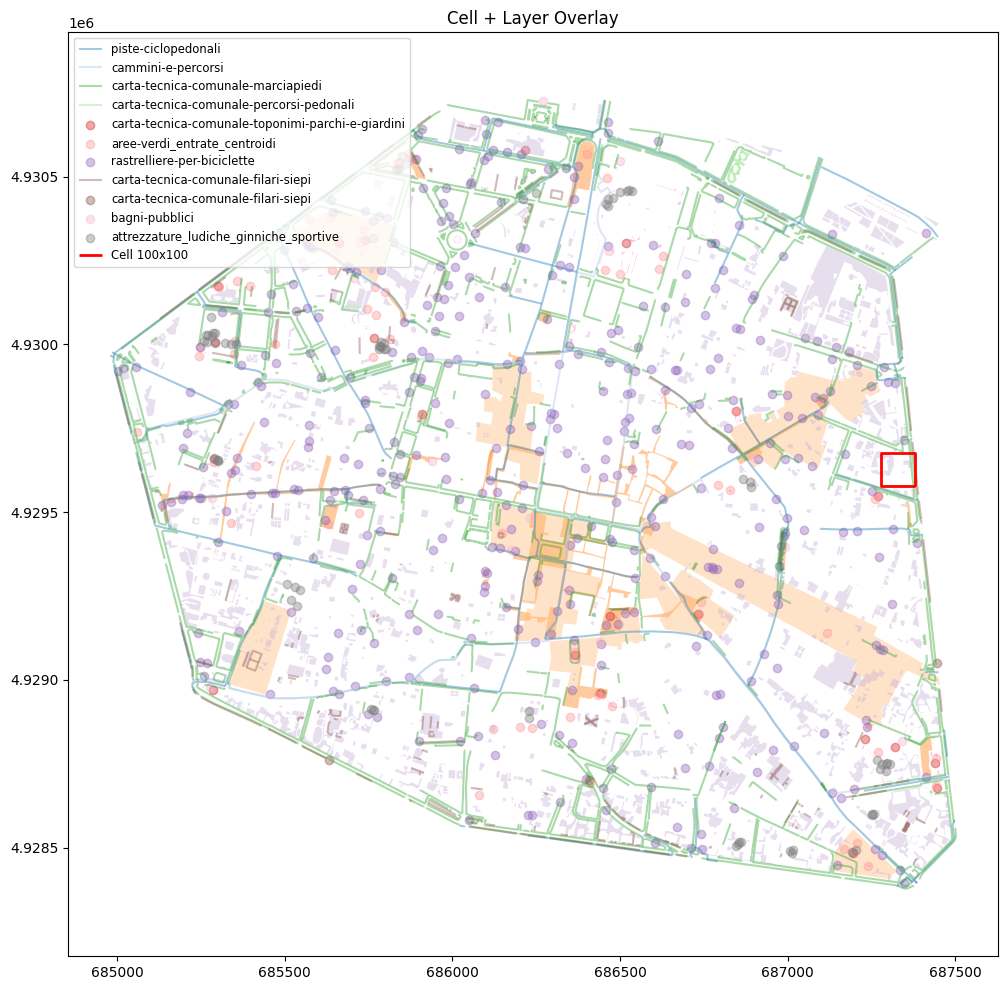

In [18]:
# Show a random sample of 1 cell
sample = grid.sample(1) 

for idx, row in sample.iterrows():
    box_geom = row.geometry
    match = results[results['Box'] == box_geom]

    if match.empty:
        print(f"\nCell {idx} not found.")
        continue

    coverage = match['Coverage'].values[0]
    score = match['Score'].values[0]
    details = match['Details'].values[0]

    print(f"\nCell index {idx}):")
    print(f"Box: {box_geom}")
    print(f"Coverage: {round(coverage, 2):.2f}%")
    print(f"Score: {round(score, 2):.2f}")
    print("Details:")

    if isinstance(details, list):
        for name, percentage, score in details:
            print(f"- {name.replace('-', ' ')}: {round(percentage, 2):.2f}% coverage → score: {round(score, 2):.2f}")
    else:
        print(f"- {details}")  # Case: "No layer covered"

    # Visualization of the cell with the layers
    gdf_cella = gpd.GeoDataFrame(geometry=[box_geom], crs="EPSG:32632")
    fig, ax = plt.subplots(figsize=(12, 12))

    for i, layer_name in enumerate(layer_scores.keys()):
        try:
            gdf = gpd.read_file(output_gpkg, layer=layer_name).to_crs("EPSG:32632")
            if not gdf.empty:
                color = plt.cm.tab20(i % 20)
                gdf.plot(ax=ax, color=color, alpha=0.4, label=layer_name)
        except Exception as e:
            print(f"Error in layer {layer_name}: {e}")
            continue

    gdf_cella.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label="Cell 100x100")
    plt.title("Cell + Layer Overlay")
    plt.legend(loc='upper left', fontsize='small')
    plt.axis('equal')
    plt.show()


## First method: Grid Search

The placement of the grid was optimized first via grid search: the method tried different offsets and angles of rotation in different ranges, optimizing the grid placement by maximizing the total score of the grid. This ensures that we are not losing any architectural element in the consideration of the final grid. This method takes approx 3hrs to execute.

### Optimization with Grid Search

In [19]:
import numpy as np

best_score = -1
best_params = None
best_grid_gs = None

# Param ranges to explore
offset_range = np.arange(-99, 99, 20)  # from -99 to +99 meters
rotation_range = np.arange(0, 89, 30)    # from 0° to 89° in steps of 15°

for dx in offset_range:
    for dy in offset_range:
        for rot in rotation_range:
            print(f"Testing dx={dx}, dy={dy}, rot={rot}°")
            # Create grid with current parameters
            grid = create_grid(city_center_df, cell_size, offset_x=dx, offset_y=dy, rotazione=rot)
            
            # Calculate scores for the grid
            grid["Score"] = grid.geometry.apply(lambda cell: evaluate_cell(cell, layer_scores, layer_gdfs)[0])
            total_score = grid["Score"].sum()
            
            print(f"dx={dx}, dy={dy}, rot={rot}° → score={total_score:.2f}")
            print("-" * 40)
            print()
            
            if total_score > best_score:
                best_score = total_score
                best_params = (dx, dy, rot)
                best_grid_gs = grid.copy()


Testing dx=-99, dy=-99, rot=0°
dx=-99, dy=-99, rot=0° → score=12524000.00
----------------------------------------

Testing dx=-99, dy=-99, rot=30°
dx=-99, dy=-99, rot=30° → score=12447250.00
----------------------------------------

Testing dx=-99, dy=-99, rot=60°
dx=-99, dy=-99, rot=60° → score=12390500.00
----------------------------------------

Testing dx=-99, dy=-79, rot=0°
dx=-99, dy=-79, rot=0° → score=12386000.00
----------------------------------------

Testing dx=-99, dy=-79, rot=30°
dx=-99, dy=-79, rot=30° → score=12408250.00
----------------------------------------

Testing dx=-99, dy=-79, rot=60°
dx=-99, dy=-79, rot=60° → score=12397500.00
----------------------------------------

Testing dx=-99, dy=-59, rot=0°
dx=-99, dy=-59, rot=0° → score=12557000.00
----------------------------------------

Testing dx=-99, dy=-59, rot=30°
dx=-99, dy=-59, rot=30° → score=12489250.00
----------------------------------------

Testing dx=-99, dy=-59, rot=60°
dx=-99, dy=-59, rot=60° → scor

### Results with Grid Search

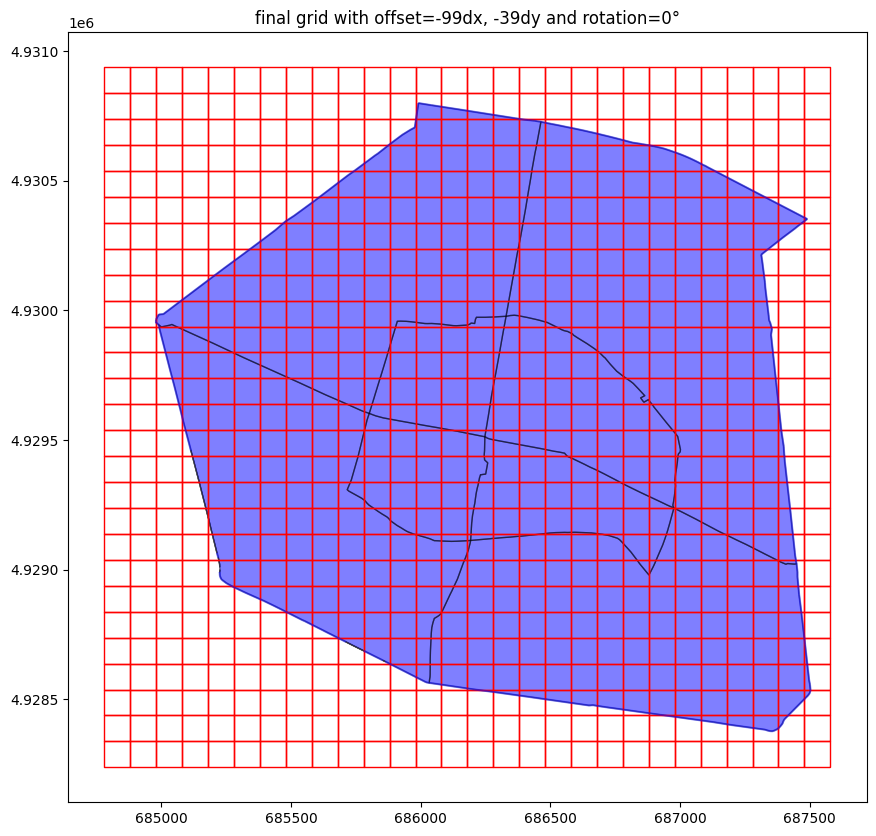

In [20]:
# Visualize final grid with best parameters
ax = city_center_df.plot(color='blue', alpha=0.5, edgecolor='k', figsize=(12,10))
best_grid_gs.plot(ax=ax, facecolor='none', edgecolor='red')
plt.title(f"final grid with offset={best_params[0]}dx, {best_params[1]}dy and rotation={best_params[2]}°")
plt.show()

In [21]:
print(f"\nBest found parameters: dx={best_params[0]}, dy={best_params[1]}, rotation={best_params[2]}°")
# Show the best score
print(f"Best score: {best_score:.2f}")


Best found parameters: dx=-99, dy=-39, rotation=0°
Best score: 12671000.00


In [22]:
# Run to evaluate again the best grid
# best_grid_gs["Valutazione"] = best_grid_gs.geometry.apply(lambda cella: evaluate_cell(cella, layer_scores, layer_gdfs)[0])

## Second method: Bayesian Optimization

Another method used was Bayesian Optimization, way faster and with pretty much the same performances of GS. The params to be optimized were the same as well as the objective function, the total score of the grid.

### Optimization with Bayesian method

In [23]:
def objective(params):
    dx, dy, rot = params
    grid = create_grid(city_center_df, cell_size=100, offset_x=dx, offset_y=dy, rotazione=rot)

    # Calculate scores for the grid
    grid["Score"] = grid.geometry.apply(lambda cell: evaluate_cell(cell, layer_scores, layer_gdfs)[0])
    total_score = grid["Score"].sum()

    print(f"dx={dx}, dy={dy}, rot={rot}° → score={total_score:.2f}")

    return -total_score  # because we want to maximize the score, we minimize its negative value

In [24]:
best_grid_bayesian = None

# Parameter search space definition
search_space = [
    Integer(-99, 99),  # offset_x
    Integer(-99, 99),  # offset_y
    Integer(0, 89),     # rotazione (gradi interi)
]

# Optimization using Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    acq_func="EI",      # Expected Improvement
    n_calls=50,         # Iterations
    random_state=42
)

dx=59, dy=-63, rot=69° → score=12434500.00
dx=19, dy=-11, rot=9° → score=12404500.00
dx=-8, dy=-33, rot=13° → score=12499250.00
dx=30, dy=-88, rot=64° → score=12404000.00
dx=87, dy=-99, rot=88° → score=12366250.00
dx=23, dy=22, rot=1° → score=12435000.00
dx=-94, dy=5, rot=36° → score=12418750.00
dx=-90, dy=94, rot=21° → score=12425500.00
dx=-81, dy=23, rot=34° → score=12403250.00
dx=96, dy=-7, rot=77° → score=12354500.00
dx=-77, dy=-91, rot=0° → score=12560000.00
dx=-99, dy=-99, rot=0° → score=12524000.00
dx=-59, dy=-85, rot=0° → score=12493000.00
dx=99, dy=-99, rot=0° → score=12525000.00
dx=99, dy=-93, rot=0° → score=12551000.00
dx=99, dy=-91, rot=10° → score=12398500.00
dx=92, dy=-99, rot=1° → score=12274000.00
dx=-73, dy=-15, rot=14° → score=12362500.00
dx=58, dy=-51, rot=12° → score=12292000.00
dx=-51, dy=-36, rot=14° → score=12353500.00
dx=99, dy=-2, rot=0° → score=12538000.00
dx=-76, dy=-42, rot=0° → score=12585000.00
dx=-75, dy=-82, rot=0° → score=12438000.00
dx=-77, dy=-9, rot=

### Results with Bayesian Optimization

In [25]:
# Best parameters found
best_dx, best_dy, best_rot = result.x
best_score = -result.fun

print("\nBest configuration found:")
print(f"Offset X: {best_dx} m")
print(f"Offset Y: {best_dy} m")
print(f"Rotation: {best_rot}°")
print(f"Max: {best_score:.2f}")

# Generate the best grid with the found parameters
best_grid_bayesian = create_grid(city_center_df, cell_size=100, offset_x=best_dx, offset_y=best_dy, rotazione=best_rot)


Best configuration found:
Offset X: 9 m
Offset Y: -41 m
Rotation: 0°
Max: 12647000.00


In [26]:
best_grid_bayesian["Score"] = best_grid_bayesian.geometry.apply(lambda cell: evaluate_cell(cell, layer_scores, layer_gdfs)[0])

## Thresholding for selecting best cells from the best grid

We select only the top 10% cells with the highest score

### Locating the best cells with both methods

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


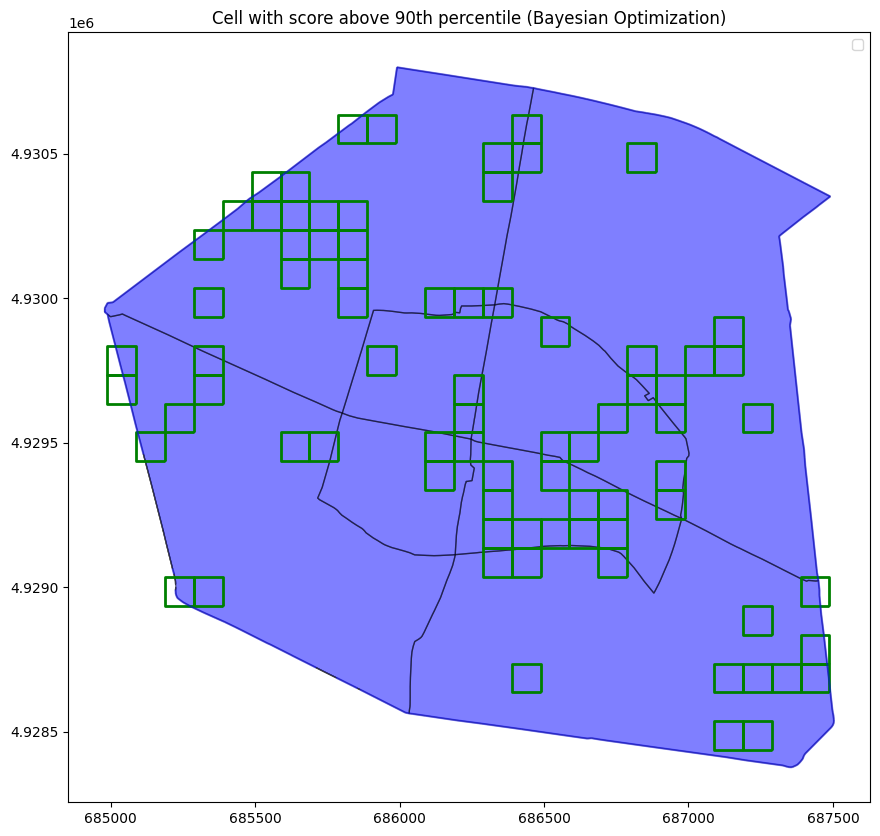

In [27]:
best_grid = best_grid_bayesian.copy() # Use grid found with bayesian optimization
# best_grid = best_grid_gs.copy()  # Use grid found with grid search

threshold = best_grid["Score"].quantile(0.90)  # Threshold for best cells (90th percentile)
best_cells_bayesian = best_grid[best_grid["Score"] >= threshold]

# Visualize the best cells
ax = city_center_df.plot(color='blue', alpha=0.5, edgecolor='k', figsize=(12,10))
best_cells_bayesian.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, label="Best Cells")
plt.title("Cell with score above 90th percentile (Bayesian Optimization)")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


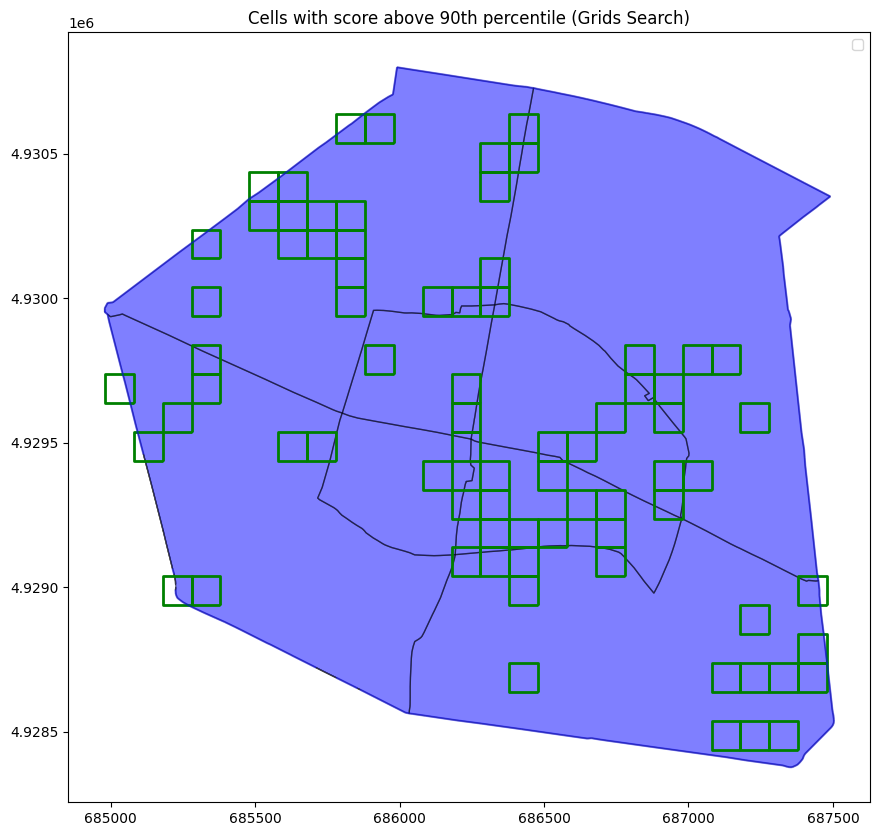

In [28]:
# best_grid = best_grid_bayesian.copy() # Use grid found with bayesian optimization
best_grid = best_grid_gs.copy()  # Use grid found with grid search

threshold = best_grid["Score"].quantile(0.90)  # Threshold for best cells (90th percentile)
best_cells_gs = best_grid[best_grid["Score"] >= threshold]

# Visualize the best cells
ax = city_center_df.plot(color='blue', alpha=0.5, edgecolor='k', figsize=(12,10))
best_cells_gs.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, label="Celle Migliori")
plt.title("Cells with score above 90th percentile (Grids Search)")
plt.legend()
plt.show()

In [29]:
# save the best grid with the highest score
best_grid_gs.to_file("Data/outputs_gpkg/best_grid_gs.gpkg", layer="best_grid", driver="GPKG")
# save the best grid with the highest score from bayesian optimization
best_grid_bayesian.to_file("Data/outputs_gpkg/best_grid_bayesian.gpkg", layer="best_grid_bayesian", driver="GPKG")


In [33]:
# save the best cells with the highest score
best_cells_gs.to_file("Data/outputs_gpkg/best_cells_gs.gpkg", layer="best_cells_gs", driver="GPKG")

# save the best cells with the highest score from bayesian optimization
best_cells_bayesian.to_file("Data/outputs_gpkg/best_cells_bayesian.gpkg", layer="best_cells_bayesian", driver="GPKG")

### Interactive Map of the best cells with both methods

An interactive map is created with the location of the best cells selected with both methods, as well as the visualization of the scores of the single cells based on color map intensity.

In [34]:
import folium
import geopandas as gpd
from branca.colormap import linear

m = folium.Map(location=[44.4949, 11.3426], zoom_start=13, tiles=None)

layers_OSM = [
    "037006_Bologna-2025-03-12T15Z — lines",
    "037006_Bologna-2025-03-12T15Z — multilinestrings",
    "037006_Bologna-2025-03-12T15Z — multipolygons",
    "037006_Bologna-2025-03-12T15Z — points",
    "037006_Bologna-2025-03-12T15Z — other_relations"
]

layers.append("best_cells_bayesian")
layers.append("best_cells_gs")
layers_cells = ["best_cells_bayesian", "best_cells_gs"]
layers_map = set(layers) - set(layers_OSM)

# Definizione delle due colormap separate
colormap_bayesian = linear.YlOrRd_09.scale(0, 1)
colormap_bayesian.caption = 'Score - Bayesian'

colormap_gs = linear.Greens_09.scale(0, 1)
colormap_gs.caption = 'Score - GS'

# Funzione stile con colormap dedicata
def get_colored_style_function(colormap):
    def style_function(feature):
        try:
            val = float(feature['properties'].get('Score', 0))
        except:
            val = 0
        color = colormap(val)
        return {
            "color": color,
            "weight": 2,
            "fillColor": color,
            "fillOpacity": 0.7
        }
    return style_function

for layer_name in layers:
    try:
        if layer_name in layers_cells:
            gdf = gpd.read_file("Data/outputs_gpkg/" + layer_name + ".gpkg")
            if gdf.crs != "EPSG:4326":
                gdf = gdf.to_crs(epsg=4326)
            if "Score" in gdf.columns:
                max_val = gdf["Score"].max()
                if max_val > 0:
                    gdf["Score"] = gdf["Score"] / max_val
        else:
            gdf = gpd.read_file(gpkg_path, layer=layer_name)

        if gdf.empty or 'geometry' not in gdf.columns:
            continue

        for col in gdf.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns:
            gdf[col] = gdf[col].astype(str)

        if layer_name in layers_OSM:
            folium.TileLayer('OpenStreetMap').add_to(m)
            continue

        fg = folium.FeatureGroup(name=layer_name, show=False)
        popup_fields = [col for col in gdf.columns if col != 'geometry' and not col.lower().endswith('id')]

        if layer_name == "best_cells_bayesian":
            style_func = get_colored_style_function(colormap_bayesian)
        elif layer_name == "best_cells_gs":
            style_func = get_colored_style_function(colormap_gs)
        else:
            style_func = lambda x: {
                "color": "blue",
                "weight": 2,
                "fillColor": "blue",
                "fillOpacity": 0.3
            }

        folium.GeoJson(
            gdf,
            name=layer_name,
            popup=folium.GeoJsonPopup(fields=popup_fields),
            tooltip=folium.GeoJsonTooltip(
                fields=popup_fields,
                aliases=[f"{f}: " for f in popup_fields],
                localize=True,
                sticky=True,
                labels=True,
                style="background-color: white; border: 1px solid black; padding: 5px;"
            ),
            style_function=style_func
        ).add_to(fg)

        fg.add_to(m)

    except Exception as e:
        print(f"Error with layer {layer_name}: {e}")

# Add the colormaps to the map
colormap_bayesian.add_to(m)
colormap_gs.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("maps/map_with_best_cells_bologna.html")


In [35]:
# zip file maps/map_with_best_cells_bologna.html
zip_path = "maps/map_with_best_cells_bologna.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(zip_path, arcname="map_with_best_cells_bologna.html")